In [7]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# libs for time measurement
from timeit import default_timer as timer
from datetime import timedelta
random_seed = 1337

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

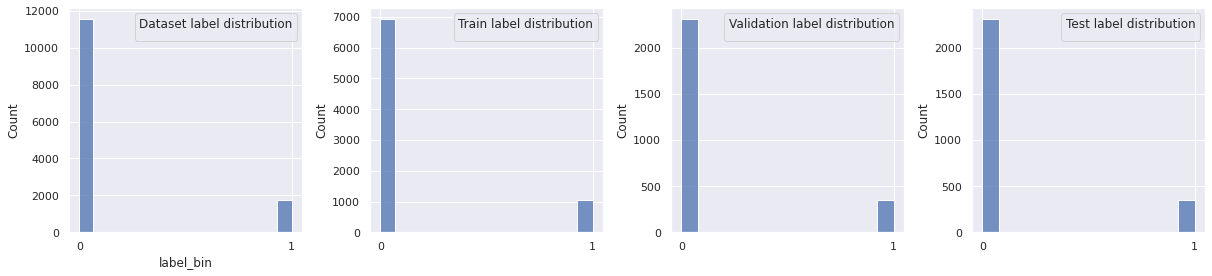

In [145]:
#get and prepare training data
def get_training_data(dataset_path:str, y_label_col="label_train", test_split_ratio:float=0.1,verbose=False):
    data = pd.read_json(dataset_path)
    data["label_train"] = data["label"] - 1
    data["label_bin"] = data['label_train'].apply(lambda x: 1 if x > 1 else 0)
    data["display_text"] = [d[1]['text'][d[1]['displayTextRangeStart']: d[1]['getDisplayTextRangeEnd']] for d in data[["text","displayTextRangeStart", "getDisplayTextRangeEnd"]].iterrows()]
    if verbose : print("max text length", len(data.iloc[np.argmax(data['text'].to_numpy())]['text']))
    max_display_text_length = len(data.iloc[np.argmax(data['display_text'].to_numpy())]['display_text'])
    if verbose : print("max display text length", max_display_text_length)
        
    X = data.display_text.to_numpy()
    y = data[y_label_col].to_numpy()
    # split data
    
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    
    for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=test_split_ratio, random_state=random_seed).split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
    X_val = None
    y_val = None   
    for train_index, val_index in StratifiedShuffleSplit(n_splits=1, test_size=test_split_ratio * len(X) / len(X_train), random_state=random_seed).split(X_train, y_train):
        X_val = X_train[val_index]
        y_val = y_train[val_index]
        X_train = X_train[train_index]
        y_train = y_train[train_index]
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_ratio, random_state=random_seed, shuffle=True)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_split_ratio * len(X) / len(X_train), random_state=random_seed, shuffle=True)
    return X_train.tolist(), y_train.tolist(), X_val.tolist(), y_val.tolist(), X_test.tolist(), y_test.tolist(), data

def plot_hist(data, title=""):
    sns.histplot(data).set_title(title)
    plt.xticks(np.unique(data))
    plt.show()

def plot_four_hists(data1, data2, data3, data4, title1="", title2="", title3="", title4=""):
    fig, ax =plt.subplots(1,4, figsize=(17,4))
    sns.histplot(data1, ax = ax[0])
    sns.histplot(data2, ax = ax[1])
    sns.histplot(data3, ax = ax[2])
    sns.histplot(data4, ax = ax[3])
    ax[0].legend(labels=[], title=title1)
    ax[1].legend(labels=[], title=title2)
    ax[2].legend(labels=[], title=title3)
    ax[3].legend(labels=[], title=title4)
    ax[0].set_xticks(np.unique(data1))
    ax[1].set_xticks(np.unique(data2))
    ax[2].set_xticks(np.unique(data3))
    ax[3].set_xticks(np.unique(data4))
    fig.tight_layout()
    fig.show()

label_col = 'label_bin'
X_train, y_train, X_val, y_val, X_test, y_test, data = get_training_data('data/dataset_full.json', y_label_col=label_col, test_split_ratio=0.2)

plot_four_hists(data[label_col], y_train, y_val, y_test, title1="Dataset label distribution", title2="Train label distribution", title3="Validation label distribution", title4="Test label distribution")

In [146]:
def compute_metrics(pred, labels):
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=100, epochs=3, model=None, tokenizer=None, model_name = 'distilbert-base-uncased'):
    
    # correct validation set length if it is too long
    ratio = 4
    if len(y_train) / ratio > len(y_val):
        X_val = X_val[0:math.ceil(len(X_val) / ratio)]
        y_val = y_val[0:math.ceil(len(y_val) / ratio)]
    
#     if len(y_train) / ratio > len(y_test):
#         X_test = X_test[0:math.ceil(len(X_test) / ratio)]
#         y_test = y_test[0:math.ceil(len(y_test) / ratio)]
    
    # BEGIN disable logging 
    import logging
    def set_global_logging_level(level=logging.ERROR, prefices=[""]):
        import re
        prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
        for name in logging.root.manager.loggerDict:
            if re.match(prefix_re, name):
                logging.getLogger(name).setLevel(level)
    set_global_logging_level(logging.CRITICAL) # disable INFO and DEBUG logging everywhere
    
    import warnings
    warnings.filterwarnings("ignore")
    # END disable logging
    
    # BEGIN Set determinism !! must be inside function in every loop to work

    from os import environ
    environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # !! important !! import torch after setting cublas deterministic or it will not work !!
    import torch
    from transformers import TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification
    import transformers
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    import random
    random.seed(random_seed)
    
    # END Set determinism
    
     # Create torch dataset
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels=None):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            if self.labels: item["labels"] = torch.tensor(self.labels[idx])
            return item
        def __len__(self):
            return len(self.encodings["input_ids"])
    
    #disable logging
    #transformers.logging.set_verbosity(transformers.logging.CRITICAL)
    
    # create tokenizer
    if tokenizer is None:
        tokenizer = DistilBertTokenizer.from_pretrained('./distilbert-base-uncased') 
    
    # create datasets
    train_dataset = Dataset(tokenizer(X_train, truncation=True, padding=True, max_length=512), y_train)
    val_dataset = Dataset(tokenizer(X_val, truncation=True, padding=True, max_length=512), y_val)
    test_dataset = Dataset(tokenizer(X_test, padding=True, truncation=True, max_length=512), y_test)
    
    #create model

    if model is None:
        model = DistilBertForSequenceClassification.from_pretrained('./distilbert-base-uncased', num_labels=len(np.unique(y_train)))


    #training settings
    args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",
        eval_steps=1,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        seed=random_seed,
        load_best_model_at_end=False
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: compute_metrics(p[0], p[1])
    )
    # disable print log
    from transformers.trainer_callback import PrinterCallback
    trainer.remove_callback(PrinterCallback)

    # Train
    trainer.train()

    # Test
    metrics = trainer.evaluate(test_dataset, metric_key_prefix="")

#     raw_pred, _, _ = trainer.predict(test_dataset)
#     m = compute_metrics(raw_pred, y_test)
    return metrics, trainer, trainer.model, tokenizer

In [147]:
metrics1, trainer1, model1, tokenizer1 = train_model(X_train, y_train, X_val, y_val, X_test, y_test)
metrics2, trainer2, model2, tokenizer2 = train_model(X_train, y_train, X_val, y_val, X_test, y_test)
metrics1, metrics2

({'_loss': 0.12983636558055878,
  '_accuracy': 0.9613072877535688,
  '_precision': 0.9611682712214616,
  '_recall': 0.9613072877535688,
  '_f1': 0.9612353223615805,
  '_runtime': 2.6206,
  '_samples_per_second': 1015.801,
  '_steps_per_second': 10.303,
  'epoch': 3.0},
 {'_loss': 0.12983636558055878,
  '_accuracy': 0.9613072877535688,
  '_precision': 0.9611682712214616,
  '_recall': 0.9613072877535688,
  '_f1': 0.9612353223615805,
  '_runtime': 2.6183,
  '_samples_per_second': 1016.695,
  '_steps_per_second': 10.312,
  'epoch': 3.0})

In [148]:
from bertopic import BERTopic
topic_model = BERTopic(embedding_model="all-mpnet-base-v2")
topic_model.fit(X_train)

In [149]:
def get_bert_topic_args(sentences, samples:int):
    l = len(sentences)
    if (l <= samples): return list(range(0, l))
    selected = []
    raw_topics = topic_model.transform(sentences)
    topics = {}
    for i in range(len(raw_topics[0])):
        t = raw_topics[0][i]
        if t not in topics:
            topics[t] = []
        topics[t].append(i)

    # use round robin to get diversity terms from every topic
    while len(selected) < samples:
        for t in topics:
            if len(topics[t]) > 0:
                pick = topics[t][0]
                if pick not in selected:
                    selected.append(pick)
                    topics[t].remove(pick)
                    if len(selected) >= samples:
                        return selected
    return selected

In [150]:
res_bt = get_bert_topic_args(X_train, samples=5)
res_bt

[0, 1, 7, 9, 13]

In [151]:
def sbert_tokenize(sentences, verbose=False, bert_model_name='all-mpnet-base-v2'):
    from sentence_transformers import SentenceTransformer, util
    import torch
    model = SentenceTransformer(bert_model_name)
    model.max_seq_length = np.argmax(sentences)
    
    embedding_list = model.encode(sentences, show_progress_bar=verbose)
    return embedding_list

# precalculate encoded sentences to achieve a better performance on sbert
encoded_sentences = sbert_tokenize(X_train)
encoded_sentences_dict = {X_train[i]:encoded_sentences[i] for i in range(len(encoded_sentences))}

def get_sbert_centroid_args(sentences, num_labels:int, bert_model_name='all-mpnet-base-v2', verbose=False):
    l = len(sentences)
    if l <= 0: return []
    
    # if sample size is smaller than the list there is nothing to sample  then return all indices
    if l < num_labels: return list(range(0, l))
    
    # encode embeddings
    embedding_list = []
    try:
        embedding_list = [encoded_sentences_dict[s] for s in sentences]
    except:
        # if list cannot be encoded with precalculated list - load new SentenceTransformer
        from sentence_transformers import SentenceTransformer, util
        import torch
        model = SentenceTransformer(bert_model_name)
        model.max_seq_length = np.argmax(sentences)
        embedding_list = model.encode(sentences, show_progress_bar=verbose)
    
    from sklearn.cluster import KMeans
    
    clustering_model = KMeans(n_clusters=num_labels, random_state=1337) 
    clustering_model.fit(embedding_list)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(sentence_id)

    centroids = []
    for i in range(len(clustering_model.cluster_centers_)):
        center = clustering_model.cluster_centers_[i]
        # get centroid arg for cluster by min euclidian distance from cluster center
        centroid_arg = clustered_sentences[i][np.argmin([np.linalg.norm(embedding_list[cluster_item_arg]-center) for cluster_item_arg in clustered_sentences[i]])]
        centroids.append(centroid_arg)
    return centroids

In [152]:
centroid_args = get_sbert_centroid_args(sentences=X_train, num_labels=5)
centroid_args.sort()
centroid_args

[454, 1264, 1300, 2026, 2758]

In [153]:
def get_random_sampling_args(embedding_list, num_labels:int, verbose=False):
    l = len(embedding_list)
    if l <= 0: return []
    # if sample size is smaller than the list there is nothing to sample then return all indices
    if l < num_labels: return list(range(0, l))
    import random
    random.seed(1337) 
    return random.sample(range(0, l), num_labels)

In [154]:
random_args = get_random_sampling_args(embedding_list=X_train, num_labels=5)
random_args.sort()
random_args

[2997, 4368, 5060, 5815, 7581]

In [169]:
def apply_active_learning(algorithm, source, source_y, stop_at=None, sample_size=200, epochs=3, continuous_mode=True, title="AL", verbose=False):
    res = []
    source = list(source)
    source_y = list(source_y)
    i = 1
    samples = []
    samples_y = []
    model = None
    tokenizer = None
    if stop_at is None: stop_at = len(source)
    while len(source) > 0 and i * sample_size <= stop_at:
        trained_samples = sample_size * i
        #if verbose : print(f'AL {title} {"Continuous" if continuous_mode else ""} processing_samples: {trained_samples}')
        start_round = timer()
        if continuous_mode:
            samples = []
            samples_y = []
        start_al = timer()
        pick_args = algorithm(source, sample_size)
        #sort reverse or pop will end with argument out of range exception
        pick_args.sort(reverse=True)
        
        duration_al = timedelta(seconds=timer()-start_al)
        #if verbose : print(f'AL {title} {"Continuous" if continuous_mode else ""} - AL duration: {duration_al}')
        # transfer samples from embedding list to samples
        for d in pick_args: 
            samples.append(source.pop(d))
            samples_y.append(source_y.pop(d))
            
        start_ml = timer()   
        metric, trainer, model, tokenizer = train_model(samples, samples_y, X_val, y_val, X_test, y_test, epochs=epochs, model=model if continuous_mode else None, tokenizer=tokenizer)
        duration_ml = timedelta(seconds=timer()-start_ml)
        #if verbose : print(f'AL {title} {"Continuous" if continuous_mode else ""} - ML duration: {duration_ml}')
        metric["trained_samples"] = trained_samples
        
        duration_total = timedelta(seconds=timer()-start_round)
        if verbose: print(f'{title}{"-C" if continuous_mode else ""} - Samples:{trained_samples} - Duration: {duration_total} AL:{duration_al} ML:{duration_ml}', end="\r")
        metric["duration_al"] = duration_al
        metric["duration_ml"] = duration_ml
        metric["duration_total"] = duration_total
        res.append(metric)
        i = i + 1
    return pd.DataFrame(res)


def print_plot(res_rand, res_sbert, res_bt, title="Experiments"):
    fig, ax =plt.subplots(1,2, figsize=(18,7))
    sns.lineplot(data=res_rand, x = "trained_samples" ,y = "_accuracy",  color='orange', linewidth=1, ax = ax[0])
    sns.lineplot(data=res_sbert, x = "trained_samples" ,y = "_accuracy",  color='blue', linewidth=1, ax = ax[0])
    sns.lineplot(data=res_bt, x = "trained_samples" ,y = "_accuracy",  color='green', linewidth=1, ax = ax[0])

    sns.lineplot(data=res_rand, x = "trained_samples" ,y = "_f1",  color='orange', linewidth=1, ax = ax[1])
    sns.lineplot(data=res_sbert, x = "trained_samples" ,y = "_f1",  color='blue', linewidth=1, ax = ax[1])
    sns.lineplot(data=res_bt, x = "trained_samples" ,y = "_f1",  color='green', linewidth=1, ax = ax[1])
    ax[0].legend(labels=["Random", "SBERT", "BERTopic"], title = "Accuracy " + title)
    ax[1].legend(labels=["Random", "SBERT", "BERTopic"], title = "F1 " + title)
    fig.show()
    
def run_experiments(X_e, y_e, sample_size, stop_at=None,  verbose=True):
    start_ex = timer()
    res_rand = apply_active_learning(get_random_sampling_args, X_e, y_e, stop_at=stop_at, sample_size=sample_size, title="RD", verbose=verbose) 
    res_sbert = apply_active_learning(get_sbert_centroid_args, X_e, y_e, stop_at=stop_at, sample_size=sample_size, title="SB", verbose=verbose)
    res_bt = apply_active_learning(get_bert_topic_args, X_e, y_e, stop_at=stop_at, sample_size=sample_size, title="BT", verbose=verbose)
    print_plot(res_rand, res_sbert, res_bt, title=f'Sample Size {sample_size}')
    duration = timedelta(seconds=timer()-start_ex)
    return {
            'res_rand': res_rand, 
            'res_sbert': res_sbert, 
            'res_bt': res_bt, 
            'duration' : duration
           }

0:29:56.681389                                                                       


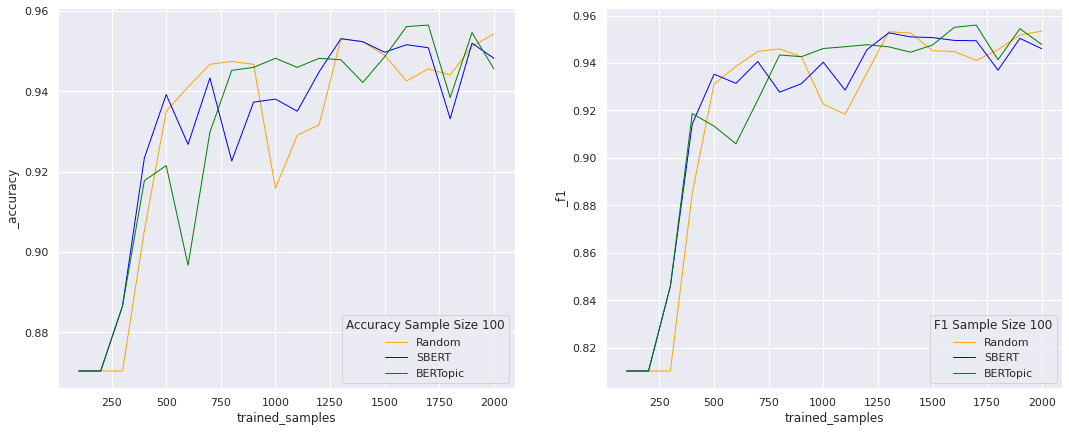

In [172]:
ex_100 = run_experiments(X_train, y_train, sample_size=100, stop_at=2000)
print(f'{ex_100["duration"]})                                                                       ')

0:51:06.457630                                                                       


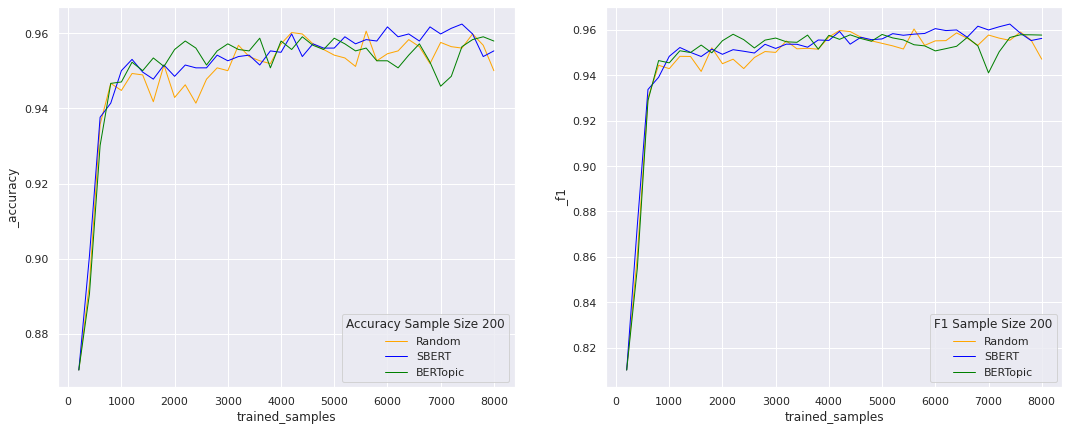

In [160]:
ex_200 = run_experiments(X_train, y_train, sample_size=200, stop_at=600)
print(f'{ex_200["duration"]}                                                                       ')

0:30:14.673037                                                                       


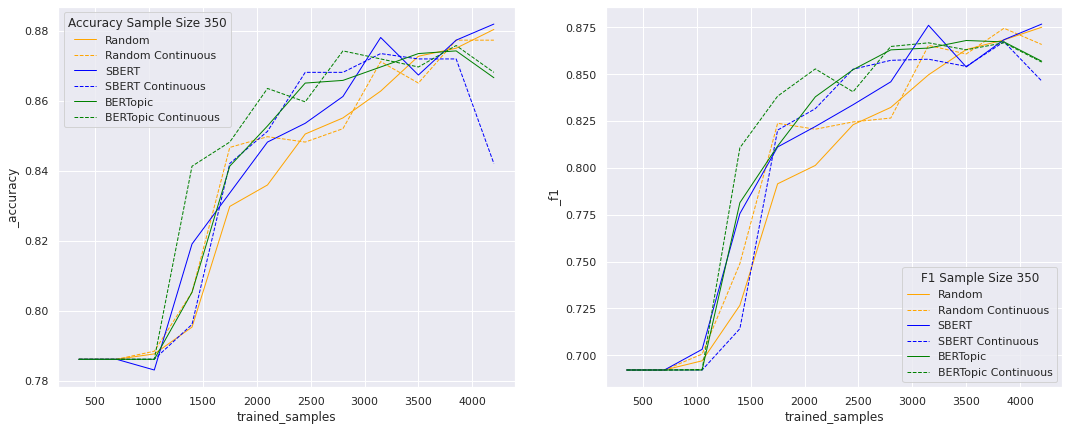

In [16]:
ex_350 = run_experiments(X_train, y_train, sample_size=350)
print(f'{ex_350["duration"]}                                                                       ')

0:21:34.166344                                                                       


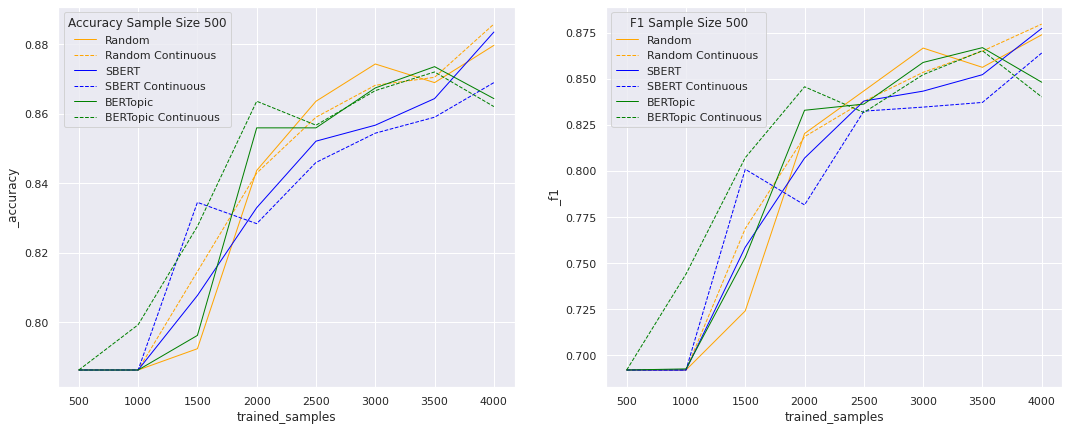

In [17]:
ex_500 = run_experiments(X_train, y_train, sample_size=500)
print(f'{ex_500["duration"]}                                                                       ')

0:17:43.101278                                                                       


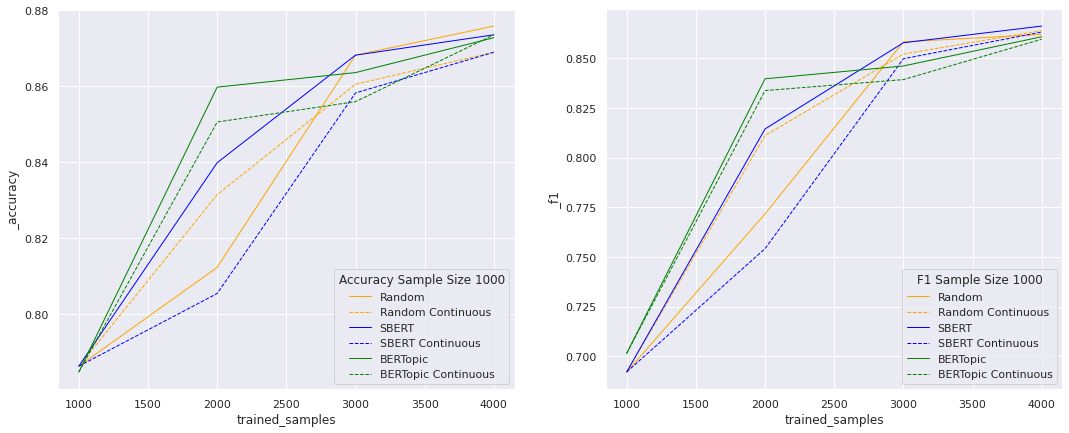

In [18]:
ex_1000 = run_experiments(X_train, y_train, sample_size=1000, stop_at=1000)
print(f'{ex_1000["duration"]}                                                                       ')